In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import seaborn as sns
from scipy import stats
from sklearn.model_selection import train_test_split
import os
import pickle

from sklearn.preprocessing import MinMaxScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import ElasticNet

from sklearn.metrics import mean_squared_error, r2_score

Source of knowledge: https://towardsdatascience.com/the-complete-guide-to-time-series-forecasting-using-sklearn-pandas-and-numpy-7694c90e45c1

In [2]:
%run Modeling_Utils.ipynb

## Load Data

In [3]:
load_data = LoadData()
PM_data = load_data.load_PM_data()
Rain_data = load_data.load_Rain_data()

## Pre-processing

In [4]:
# Start with rain data
rain_TS = pd.concat([value.set_index('Date') for value in Rain_data.copy().values()], axis=0).fillna(0).rename(columns={'73T':'Rain_73T'})
rain_TS.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1096 entries, 2018-01-01 to 2019-12-31
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Rain_73T  1096 non-null   float64
dtypes: float64(1)
memory usage: 17.1 KB


<AxesSubplot: xlabel='Date'>

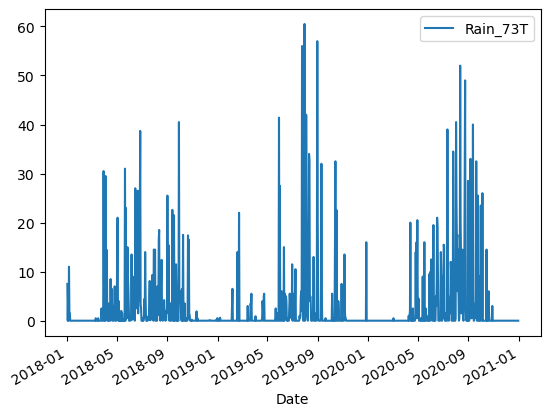

In [5]:
rain_TS.plot()

In [6]:
scope_year = [2018, 2019, 2020]
PM_TS = station_data_TS(PM_data, '73T', scope_year=scope_year)
PM_TS.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1092 entries, 2020-01-01 to 2019-12-31
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   PM_73T  1092 non-null   float64
dtypes: float64(1)
memory usage: 17.1 KB


<AxesSubplot: xlabel='Date'>

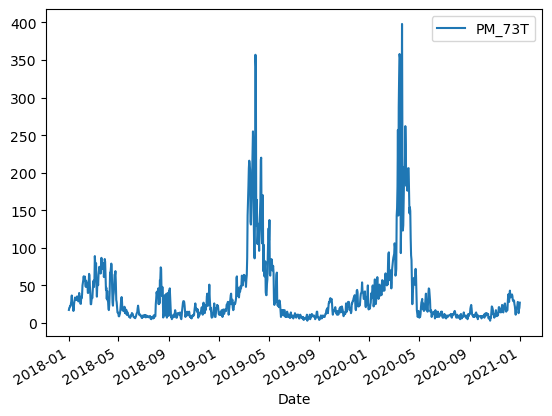

In [7]:
PM_TS.plot()

In [8]:
Data = pd.concat([rain_TS, PM_TS], axis=1)
Data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1096 entries, 2018-01-01 to 2020-12-31
Freq: D
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Rain_73T  1096 non-null   float64
 1   PM_73T    1092 non-null   float64
dtypes: float64(2)
memory usage: 25.7 KB


In [9]:
Data[Data['PM_73T'].isna()]

,Rain_73T,PM_73T
Date,,
2018-06-29,2.7,NaN
2019-06-29,0.5,NaN
2020-02-29,0.0,NaN
2020-06-29,0.0,NaN


<AxesSubplot: xlabel='Date'>

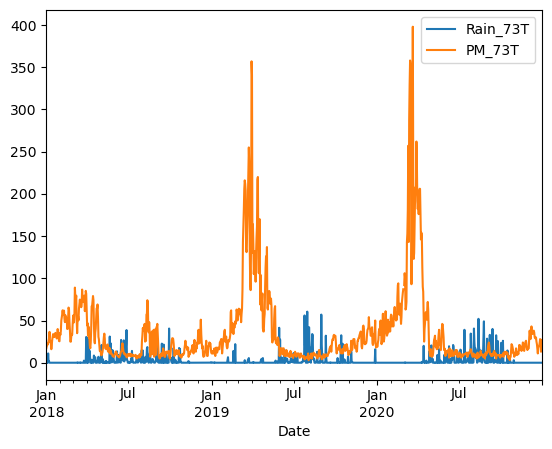

In [10]:
Data.plot()

In [11]:
# Fill nan on PM
Data['PM_73T'] = Data['PM_73T'].interpolate('linear')
Data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1096 entries, 2018-01-01 to 2020-12-31
Freq: D
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Rain_73T  1096 non-null   float64
 1   PM_73T    1096 non-null   float64
dtypes: float64(2)
memory usage: 25.7 KB


<AxesSubplot: xlabel='Date'>

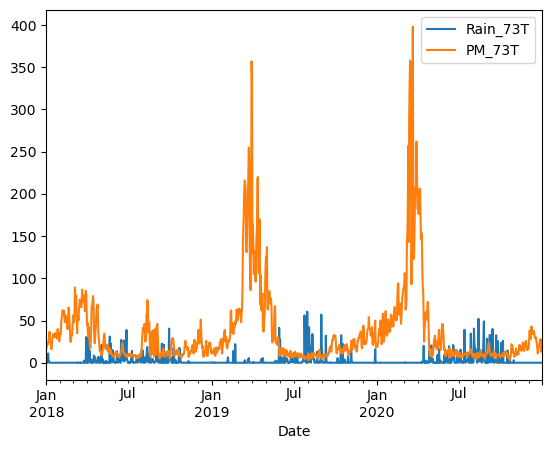

In [12]:
Data.plot()

In [13]:
Data['Date_num'] = np.arange(Data.shape[0])
Data

,Rain_73T,PM_73T,Date_num
Date,,,
2018-01-01,7.5,17.333333,0
2018-01-02,0.0,20.222222,1
2018-01-03,5.5,20.555556,2
2018-01-04,0.0,22.555556,3
2018-01-05,11.0,22.444444,4
...,...,...,...
2020-12-27,0.0,27.000000,1091
2020-12-28,0.0,13.000000,1092
2020-12-29,0.0,18.000000,1093


## Modelling

Model
- Regression
- Gradient Boosting
- K-NN

### Univariate with rain

In [189]:
# def univariate_piplines(window_length, data, column_name, target_name, portion, model):
#     # preparing data
#     new_data, add_columns = window_input(window_length, data.copy(), column_name)
#     X, y = new_data.copy()[add_columns].to_numpy(), new_data.copy()[target_name].to_numpy()
#     dim = len(add_columns)
#     minmax_model = MinMaxScaler().fit(X)
#     X = minmax_model.transform(X)
#     X_train, X_test = X[:int(X.shape[0] * portion)].reshape(-1, dim), X[int(X.shape[0] * portion):].reshape(-1, dim)
#     y_train, y_test = y[:int(y.shape[0] * portion)].reshape(-1, 1), y[int(y.shape[0] * portion):].reshape(-1, 1)

#     # train model
#     trained_model = model.fit(X_train, y_train.ravel())
#     return trained_model, minmax_model, X_test, y_test.ravel()


In [190]:
# Configuration
window_length = 3
data = Data.copy()
column_name = 'Rain_73T'
target_name = 'PM_73T'
portion = 0.8
next_timestep = [2, 5, 7, 10, 15]
model_dict = {'DecisionTree':DecisionTreeRegressor(), 'GradTree':GradientBoostingRegressor(), 
             'ElasticNet':ElasticNet()}

In [191]:
various_timestep = {}
test_dict = {}
train_dict = {}
for window_length in next_timestep:
    trained_model_dict = {}
    model_dict = {'DecisionTree':DecisionTreeRegressor(), 'GradTree':GradientBoostingRegressor(), 
             'ElasticNet':ElasticNet()}
    for model_name, model in model_dict.items():
        print(f'{model_name} at {window_length} window length')
        trained_model, minmax_model, X_train, y_train, X_test, y_test = univariate_piplines(window_length, data, column_name, target_name, portion, model)
        trained_model_dict[model_name] = trained_model
    test_dict[str(window_length)] = [X_test, y_test]
    train_dict[str(window_length)] = [X_train, y_train]
    various_timestep[str(window_length)] = trained_model_dict

DecisionTree at 2 window length
GradTree at 2 window length
ElasticNet at 2 window length
DecisionTree at 5 window length
GradTree at 5 window length
ElasticNet at 5 window length
DecisionTree at 7 window length
GradTree at 7 window length
ElasticNet at 7 window length
DecisionTree at 10 window length
GradTree at 10 window length
ElasticNet at 10 window length
DecisionTree at 15 window length
GradTree at 15 window length
ElasticNet at 15 window length


In [192]:
for window_length, trained_model_dict in various_timestep.items():
    print(f'--------------- window lenght : {window_length} ------------------')
    X_test, y_test = test_dict[window_length][0], test_dict[window_length][1]
    Evaluation_Model(trained_model_dict, X_test, y_test)
    print('----------------------------------------------------')

--------------- window lenght : 2 ------------------
Model DecisionTree
219738.66116488667 136154.08990859627
220 2
Mean squared error: 998.81
R square: -0.6138968819254924
Adjusted R square: -0.6287715075653588
-------------------------------------
Model GradTree
184597.8564428751 142978.85736473528
220 2
Mean squared error: 839.08
R square: -0.29108498868452193
Adjusted R square: -0.3029843895018909
-------------------------------------
Model ElasticNet
182947.2494413947 183120.45721122072
220 2
Mean squared error: 831.58
R square: 0.0009458679410473403
Adjusted R square: -0.008262004243827725
-------------------------------------
----------------------------------------------------
--------------- window lenght : 5 ------------------
Model DecisionTree
355528.04439040733 148851.55180624567
220 5
Mean squared error: 1616.04
R square: -1.388473886071302
Adjusted R square: -1.4442793506991358
-------------------------------------
Model GradTree
169797.658800814 129615.29557160943
220 5

In [193]:
# X_train_plot = Data['Rain_73T'].copy().iloc[:int(Data.shape[0] * portion)].to_numpy()
# X_test_plot = Data['Rain_73T'].copy().iloc[int(Data.shape[0] * portion):].to_numpy()

X_train_plot = Data['PM_73T'].copy().iloc[:int(Data.shape[0] * portion)].to_numpy()
X_test_plot = Data['PM_73T'].copy().iloc[int(Data.shape[0] * portion):].to_numpy()

Train Data


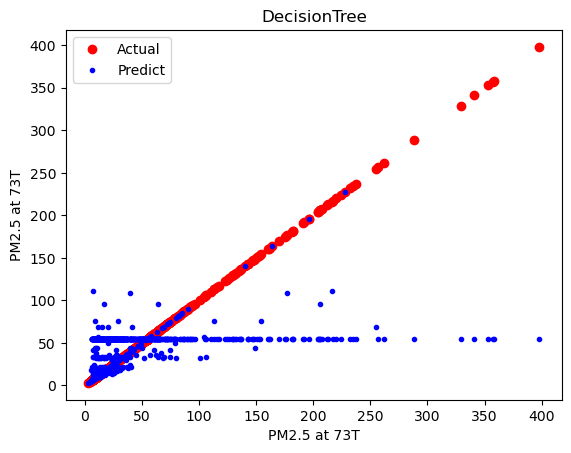

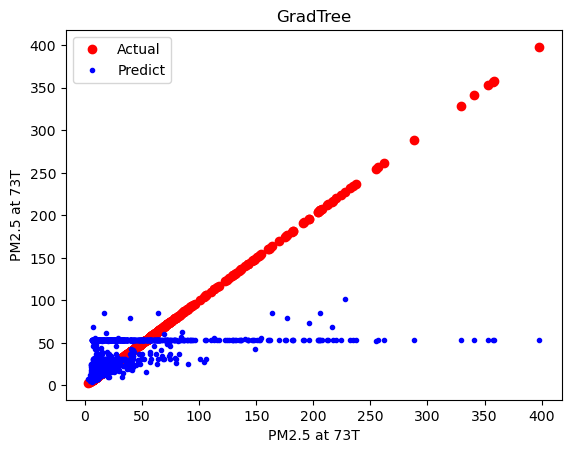

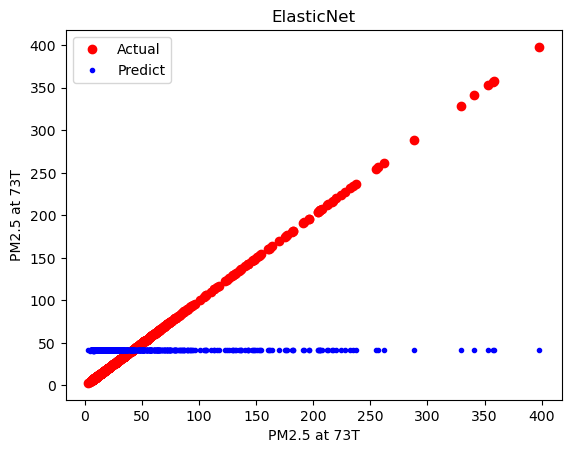

In [194]:
print('Train Data')
plot_result(train_dict, various_timestep, 2, X_train_plot)

Test Data


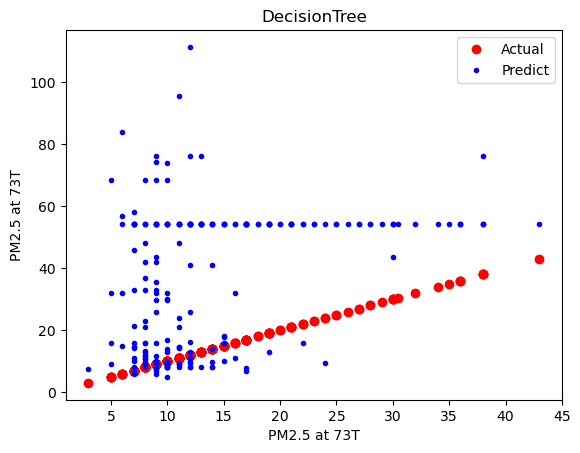

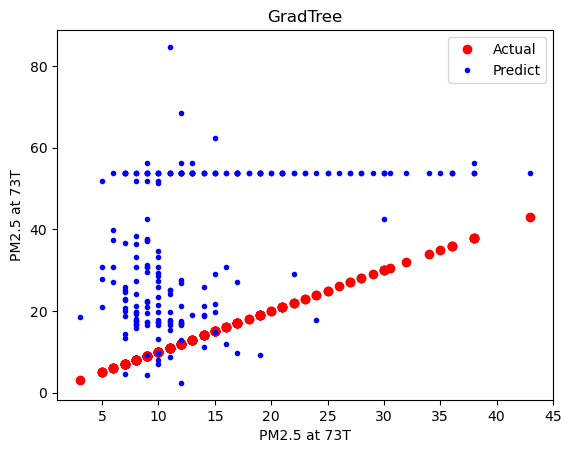

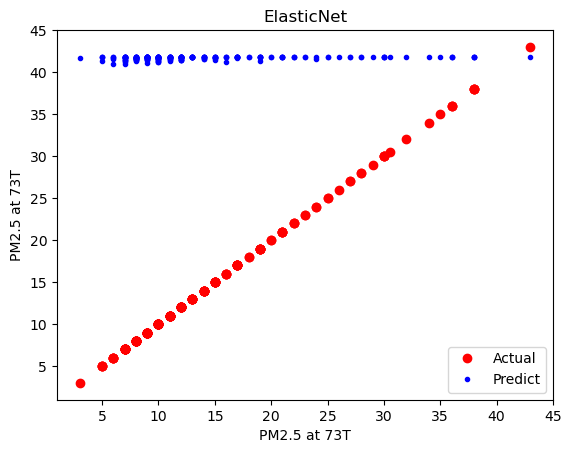

In [195]:
print('Test Data')
plot_result(test_dict, various_timestep, 2, X_test_plot)

### Univariate with date

In [196]:
data = Data.copy()
column_name = 'Date_num'
target_name = 'PM_73T'
portion = 0.8
next_timestep = [2, 5, 7, 10, 15]
model_dict = {'DecisionTree':DecisionTreeRegressor(), 'GradTree':GradientBoostingRegressor(), 
             'ElasticNet':ElasticNet()}

In [197]:
various_timestep = {}
test_dict = {}
train_dict = {}
for window_length in next_timestep:
    trained_model_dict = {}
    model_dict = {'DecisionTree':DecisionTreeRegressor(), 'GradTree':GradientBoostingRegressor(), 
             'ElasticNet':ElasticNet()}
    for model_name, model in model_dict.items():
        print(f'{model_name} at {window_length} window length')
        trained_model, minmax_model, X_train, y_train, X_test, y_test = univariate_piplines(window_length, data, column_name, target_name, portion, model)
        trained_model_dict[model_name] = trained_model
    test_dict[str(window_length)] = [X_test, y_test]
    train_dict[str(window_length)] = [X_train, y_train]
    various_timestep[str(window_length)] = trained_model_dict

DecisionTree at 2 window length
GradTree at 2 window length
ElasticNet at 2 window length
DecisionTree at 5 window length
GradTree at 5 window length
ElasticNet at 5 window length
DecisionTree at 7 window length
GradTree at 7 window length
ElasticNet at 7 window length
DecisionTree at 10 window length
GradTree at 10 window length
ElasticNet at 10 window length
DecisionTree at 15 window length
GradTree at 15 window length
ElasticNet at 15 window length


In [198]:
for window_length, trained_model_dict in various_timestep.items():
    print(f'--------------- window lenght : {window_length} ------------------')
    X_test, y_test = test_dict[window_length][0], test_dict[window_length][1]
    Evaluation_Model(trained_model_dict, X_test, y_test)
    print('----------------------------------------------------')

--------------- window lenght : 2 ------------------
Model DecisionTree
225575.25 225302.1227272726
220 2
Mean squared error: 1025.34
R square: -0.0012122711913282735
Adjusted R square: -0.010440034059451042
-------------------------------------
Model GradTree
170720.2071657742 164449.6692594304
220 2
Mean squared error: 776.00
R square: -0.03813043793023141
Adjusted R square: -0.047698460399634435
-------------------------------------
Model ElasticNet
228018.29251079386 228571.3347885959
220 2
Mean squared error: 1036.45
R square: 0.002419560958129563
Adjusted R square: -0.006774728802624974
-------------------------------------
----------------------------------------------------
--------------- window lenght : 5 ------------------
Model DecisionTree
272348.25 247008.32272727293
220 5
Mean squared error: 1237.95
R square: -0.10258734196865671
Adjusted R square: -0.12834872846325163
-------------------------------------
Model GradTree
206593.39011606548 176717.34872766805
220 5
Mean s

In [199]:
X_train_plot = Data['PM_73T'].copy().iloc[:int(Data.shape[0] * portion)].to_numpy()
X_test_plot = Data['PM_73T'].copy().iloc[int(Data.shape[0] * portion):].to_numpy()

# X_train_plot = Data['Date_num'].copy().iloc[:int(Data.shape[0] * portion)].to_numpy()
# X_test_plot = Data['Date_num'].copy().iloc[int(Data.shape[0] * portion):].to_numpy()

Train Data


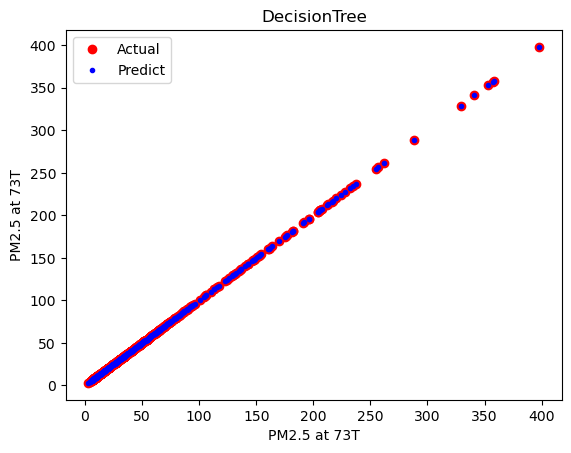

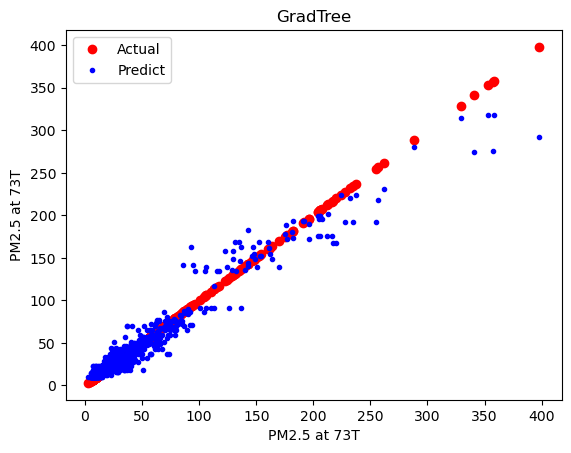

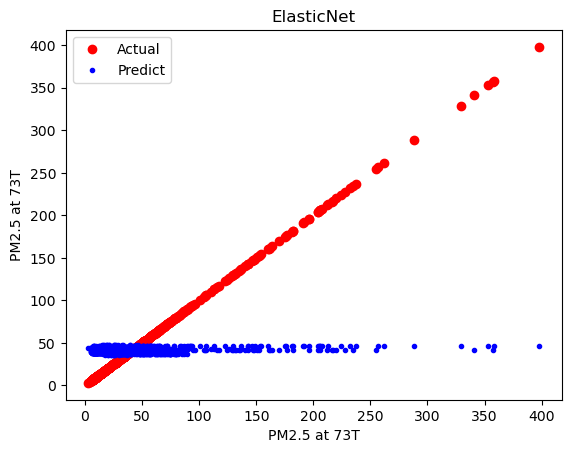

In [200]:
print('Train Data')
plot_result(train_dict, various_timestep, 5, X_train_plot)

Test Data


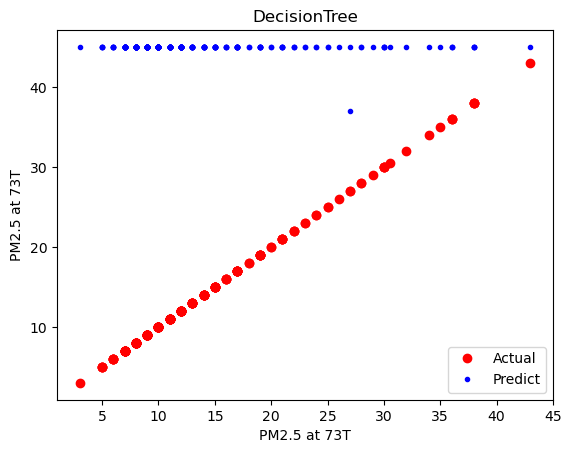

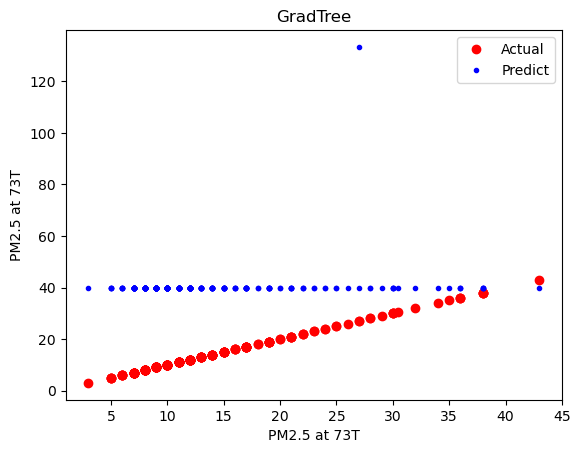

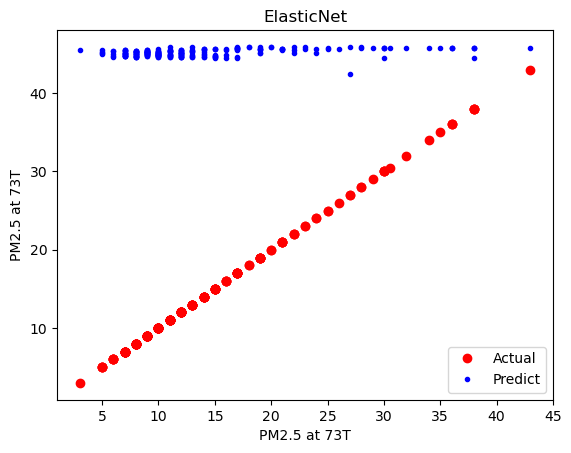

In [201]:
print('Test Data')
plot_result(test_dict, various_timestep, 2, X_test_plot)

### Multi-variate with rain and date

In [202]:
# data = Data.copy()
# column_lst = ['Date_num', 'Rain_73T']
# target_name = 'PM_73T'
# portion = 0.8
# next_timestep = [2, 5, 7, 10, 15]
# model_dict = {'DecisionTree':DecisionTreeRegressor(), 'GradTree':GradientBoostingRegressor(), 
#              'ElasticNet':ElasticNet()}

In [203]:
# various_timestep = {}
# test_dict = {}
# for window_length in next_timestep:
#     trained_model_dict = {}
#     model_dict = {'DecisionTree':DecisionTreeRegressor(), 'GradTree':GradientBoostingRegressor(), 
#              'ElasticNet':ElasticNet()}
#     for model_name, model in model_dict.items():
#         print(f'{model_name} at {window_length} window length')
#         trained_model, minmax_model, X_test, y_test = multivariate_piplines(window_length, data, column_lst, target_name, portion, model)
#         trained_model_dict[model_name] = trained_model
#     test_dict[str(window_length)] = [X_test, y_test]
#     various_timestep[str(window_length)] = trained_model_dict

In [204]:
# for window_length, trained_model_dict in various_timestep.items():
#     print(f'--------------- window lenght : {window_length} ------------------')
#     X_test, y_test = test_dict[window_length][0], test_dict[window_length][1]
#     Evaluation_Model(trained_model_dict, X_test, y_test)
#     print('----------------------------------------------------')

In [205]:
# plot_result(test_dict, various_timestep, 2)